In [1]:
import numpy as np
import pennylane as qml
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from pennylane import numpy as pnp
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from pennylane_qiskit import AerDevice

# Generate Bars and Stripes dataset
def generate_bars_and_stripes(n):
    bars = []
    stripes = []
    for i in range(1, 2**n):
        bar = np.zeros((n, n))
        stripe = np.zeros((n, n))
        for j in range(n):
            if i & (1 << j):
                bar[:, j] = 1
                stripe[j, :] = 1
        bars.append(bar.flatten())
        stripes.append(stripe.flatten())
    return bars, stripes

bars, stripes = generate_bars_and_stripes(2)

# Define the quantum circuit with Qiskit
n=2


n_qubits=n*n
# Define the hybrid model in PennyLane
#dev = qml.device('qiskit.aer', wires=n_qubits)
dev = AerDevice(wires=n_qubits, backend='aer_simulator')



@qml.qnode(dev)
def circuit(params):
    for i in range(n_qubits):
        qml.RX(params[i], wires=i)
        qml.RY(params[i+1], wires=i)
        qml.RZ(params[i+2], wires=i)

    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[2, 3])
    qml.CNOT(wires=[3, 0])

    
    
    return qml.probs(wires=range(n_qubits))

def cost(params):
    output_probs = circuit(params)
    target_probs = np.array([0.166666667, 0, 0, 0.166666667, 0, 0.166666667, 0, 0, 0, 0, 0.166666667, 0, 0.166666667, 0, 0,  0.166666667])
    cost_value = np.sum(np.abs(target_probs-output_probs))
    return cost_value

# Optimize the quantum circuit


init_params = np.random.random(n_qubits*2*3)
#init_params = np.random.uniform(high=np.pi, low=-1*np.pi, size=n_qubits*2*3)

result = minimize(cost, init_params, method='COBYLA', tol=1e-10)
optimal_params = result.x

# Evaluate and visualize the results


output_probs = circuit(optimal_params)

print(optimal_params)
print(output_probs)

[0.71457789 1.64379738 1.50870832 0.21252491 0.28380835 1.28144877
 1.56933487 0.11868766 1.71640526 1.34438049 0.15454052 0.95406665
 0.14914215 0.94396979 0.93201472 0.33787988 0.55425104 0.08448138
 0.13544685 0.90651314 0.50677902 0.37281071 0.58058215 0.78599587]
[0.1171875  0.00292969 0.00390625 0.11132812 0.09179688 0.00585938
 0.00292969 0.16601562 0.12890625 0.00195312 0.00097656 0.10351562
 0.12597656 0.00292969 0.00390625 0.12988281]


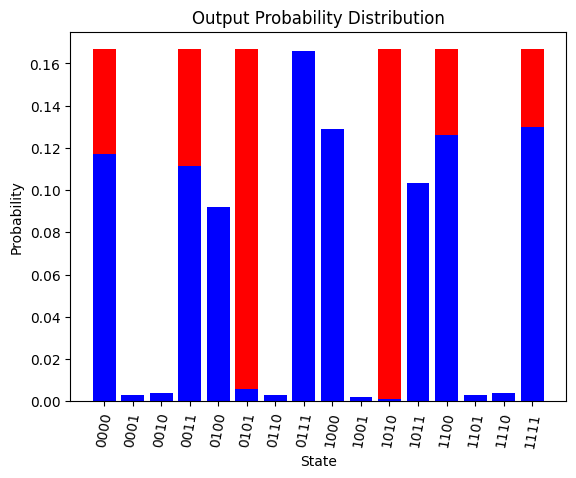

In [2]:

states = [f"{i:0{n_qubits}b}" for i in range(2**n_qubits)]
real_probs = np.array([0.166666667, 0, 0, 0.166666667, 0, 0.166666667, 0, 0, 0, 0, 0.166666667, 0, 0.166666667, 0, 0,  0.166666667])

plt.bar(states, real_probs, color='red')
plt.bar(states, output_probs, color='blue')
plt.xticks(states, rotation=80)

plt.xlabel('State')
plt.ylabel('Probability')
plt.title('Output Probability Distribution')
plt.show()
